# 00 - Instalando pacotes

In [2]:
# ! pip install requests pandas ipeadatapy statsforecast xgboost tensorflow scikit-learn matplotlib prophet

# 01 - Import de bibliotecas

In [3]:
from ipeadatapy import list_series
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from statsforecast import StatsForecast
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import joblib

# 02 - ETL

In [4]:
# Código da série no IPEA
codigo_serie = 'EIA366_PBRENT366'  #Preço por barril do petróleo bruto Brent (FOB) (EIA366_PBRENT366)

# URL da API
url = f"http://ipeadata.gov.br/api/odata4/ValoresSerie(SERCODIGO='{codigo_serie}')"

# GET de dados
response = requests.get(url)

# convertendo retorno para JSON
dados_json = response.json()

# Extraindo dados da chave 'value'
dados = dados_json['value']

# Criando DataFrame com os dados
df = pd.DataFrame(dados)

# Selecionando as colunas de interesse
df = df[['VALDATA', 'VALVALOR']]

In [5]:
print(df)

                         VALDATA  VALVALOR
0      1986-01-04T00:00:00-02:00       NaN
1      1986-01-05T00:00:00-02:00       NaN
2      1986-01-06T00:00:00-02:00       NaN
3      1986-01-07T00:00:00-02:00       NaN
4      1986-01-08T00:00:00-02:00       NaN
...                          ...       ...
13685  2025-05-06T00:00:00-03:00     62.37
13686  2025-05-07T00:00:00-03:00     60.31
13687  2025-05-08T00:00:00-03:00     62.22
13688  2025-05-09T00:00:00-03:00     64.26
13689  2025-05-12T00:00:00-03:00     65.28

[13690 rows x 2 columns]


In [6]:
# Renommeando as colunas
df.columns = ['Data', 'Valor']

In [7]:
# cortando a string de data
df['Data'] = df['Data'].str[:10]

In [8]:
# Alterando formato para data
df['Data'] = pd.to_datetime(df['Data'])

In [9]:
df.head()

,Data,Valor
0,1986-01-04,NaN
1,1986-01-05,NaN
2,1986-01-06,NaN
3,1986-01-07,NaN
4,1986-01-08,NaN


In [10]:
df.dtypes

Data     datetime64[ns]
Valor           float64
dtype: object

In [11]:
df.shape

(13690, 2)

In [12]:
df.describe()

,Data,Valor
count,13690,11420.000000
mean,2004-11-09 16:08:08.064280448,53.537249
min,1986-01-04 00:00:00,9.100000
25%,1995-05-21 06:00:00,20.730000
50%,2004-10-02 12:00:00,49.430000
75%,2014-02-14 18:00:00,76.762500
max,2025-05-12 00:00:00,143.950000
std,NaN,33.049751


In [13]:
df.dtypes

Data     datetime64[ns]
Valor           float64
dtype: object

In [14]:
# Verificar valores ausentes
print("Valores ausentes:\n", df.isnull().sum())

Valores ausentes:
 Data        0
Valor    2270
dtype: int64


In [15]:
# Dropando Valores Ausentes
df = df.dropna()

In [16]:
# Verificar duplicatas
print("Duplicadas:", df.duplicated().sum())

Duplicadas: 0


In [17]:
# Ordenar por data
df = df.sort_values("Data")

In [18]:
# Remover duplicatas, se houver
df = df.drop_duplicates()

In [19]:
# Exibir amostra final
print(df.tail(10))

            Data  Valor
13680 2025-04-28  66.13
13681 2025-04-29  64.04
13682 2025-04-30  63.37
13683 2025-05-01  62.37
13684 2025-05-02  61.57
13685 2025-05-06  62.37
13686 2025-05-07  60.31
13687 2025-05-08  62.22
13688 2025-05-09  64.26
13689 2025-05-12  65.28


# 03 - EDA (Exploratory data Analysis)

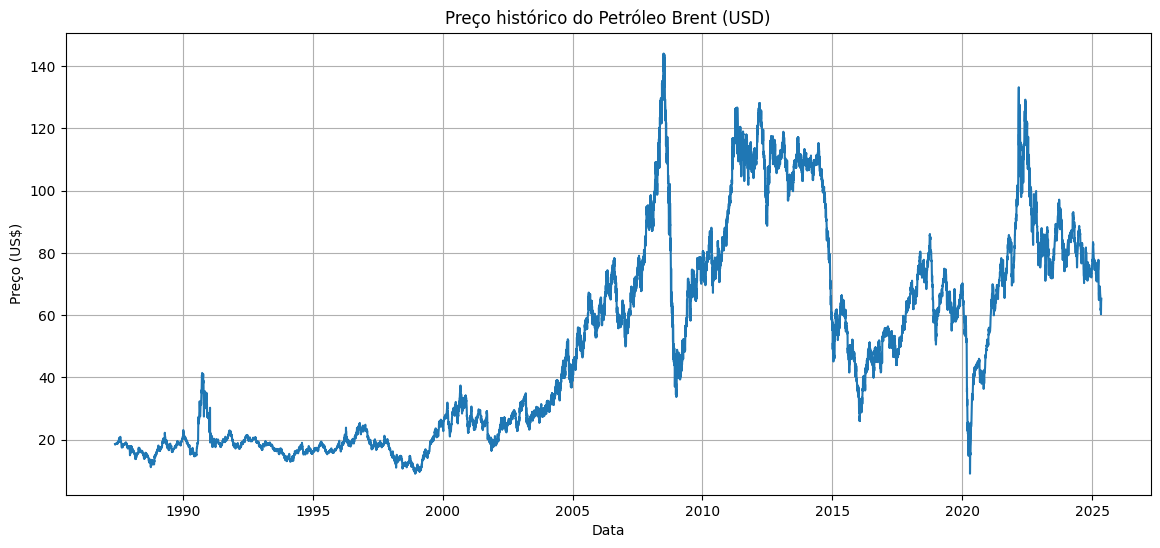

In [20]:
# Plot da Série Geral

plt.figure(figsize=(14, 6))
sns.lineplot(x="Data", y="Valor", data=df)
plt.title("Preço histórico do Petróleo Brent (USD)")
plt.xlabel("Data")
plt.ylabel("Preço (US$)")
plt.grid(True)
plt.show()

In [21]:
# # Volatilidade do preço do petróleo (com base em 30 dias)

# df["Retorno (%)"] = df["Valor"].pct_change() * 100

# # Volatilidade (rolling std de 30 dias)
# df["Volatilidade (%)"] = df["Retorno (%)"].rolling(30).std()

# # Visualizar
# plt.figure(figsize=(14, 5))
# sns.lineplot(x="Data", y="Volatilidade (%)", data=df)
# plt.title("Volatilidade (30 dias) do preço do Brent")
# plt.grid(True)
# plt.show()

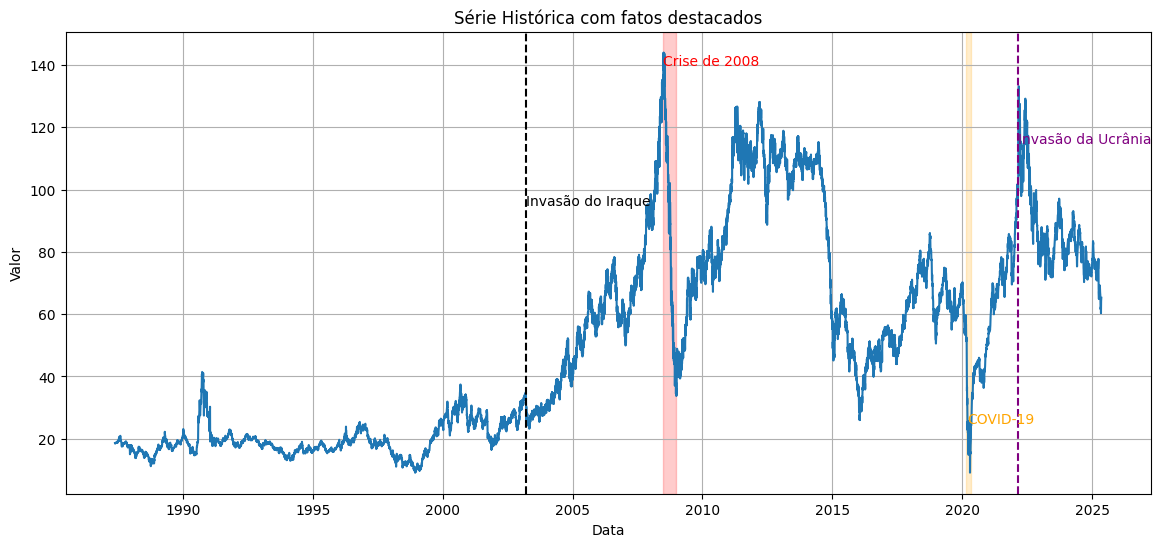

In [22]:
# Destacando diferentes períodos

'''
destacando diversos períodos dentro da série histórico como:

  - Em 2003 a Invasão do iraque (um dos países membros da OPEP) deveria em tese causar
  algum impacto na produção de petróleo que por sua vez seria notado na série histórica de preços

  - Em 2008 a crise dos subprimes nos Estados Unidos afetou em cadeia todo a economia america e também mundial,
  era esperada uma diminuição do consumo geral neste período.

  - Em 2020 a pandemia Global do Corona virus impactou diretamente a demanda por produtos e commodities,
  o impacto esperado era de uma queda no consumo e consequentemente no preço.

  - Em 2022 ocorreu a invasão da ucrânia por porte da Rússia, o que causou caos e dificuldades nos demais países UE
  Era esperado uma elevação no consumo dados que a matriz energética de muitos desses paises depende de petróleo
  e derivados no perído de inverno.

'''

plt.figure(figsize=(14, 6))
sns.lineplot(x="Data", y="Valor", data=df)

# 01 - Invsão Iraque
plt.axvline(pd.Timestamp("2003-03-20"), color="black", linestyle="--")
plt.text(pd.Timestamp("2003-03-20"), 95, "Invasão do Iraque", color="black")
# 02 - Crise 2008
plt.axvspan("2008-07-01", "2009-01-01", color="red", alpha=0.2)
plt.text(pd.Timestamp("2008-07-01"), 140, "Crise de 2008", color="red")
# 03 - Covid
plt.axvspan("2020-03-01", "2020-05-01", color="orange", alpha=0.2)
plt.text(pd.Timestamp("2020-03-10"), 25, "COVID-19", color="orange")
# 04 - Invsão Ucrania
plt.axvline(pd.Timestamp("2022-02-24"), color="purple", linestyle="--")
plt.text(pd.Timestamp("2022-02-25"), 115, "Invasão da Ucrânia", color="purple")
plt.title("Série Histórica com fatos destacados")
plt.grid(True)
plt.show()

In [23]:
# Isso insere todas as datas (com NaN nos dias faltantes)
df_decomp = df.set_index("Data").asfreq("D")

In [24]:
# Interpolação linear para preencher valores faltantes
df_decomp["Valor"] = df_decomp["Valor"].interpolate(method="linear")

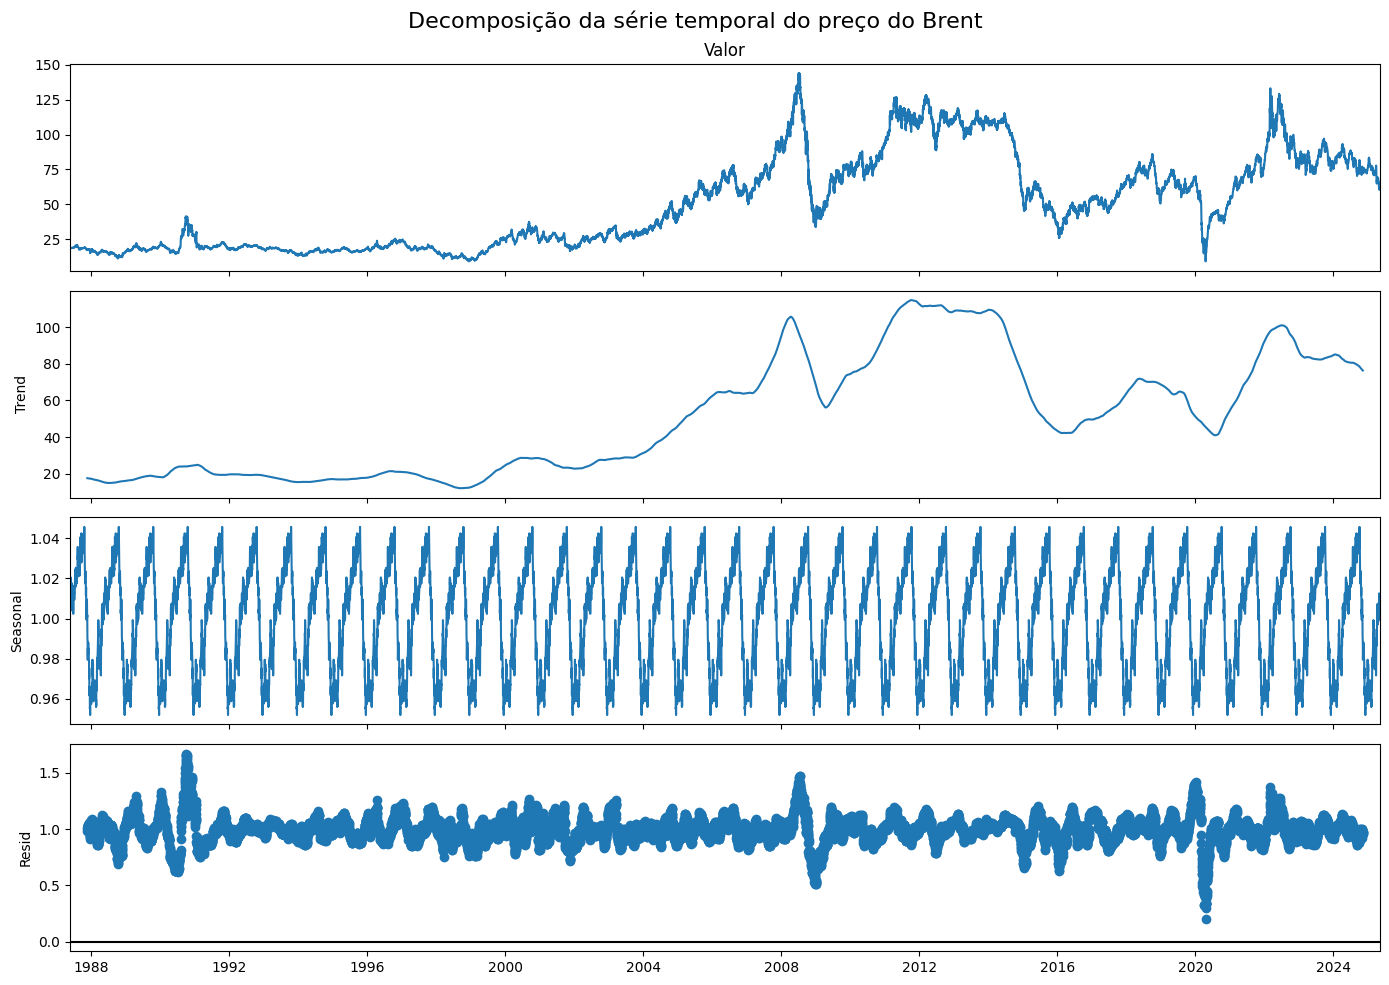

In [25]:
# Decomposição da série temporal

decomp = seasonal_decompose(df_decomp["Valor"], model="multiplicative", period=365)

# Captura o objeto da figura
fig = decomp.plot()
fig.set_size_inches(14, 10)  # Largura x Altura em polegadas

plt.suptitle("Decomposição da série temporal do preço do Brent", fontsize=16)
plt.tight_layout()
plt.show()

# 04 - Modelos

In [26]:
def avaliar_modelo(y_real, y_pred, nome_modelo):
    mae = mean_absolute_error(y_real, y_pred)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    r2 = r2_score(y_real, y_pred)

    return {
        "Modelo": nome_modelo,
        "MAE": round(mae, 3),
        "RMSE": round(rmse, 3),
        "R²": round(r2, 3)
    }

## 4.1 - Naive

In [27]:
# Usar a versão com índice diário e valores interpolados
df_naive = df.set_index("Data").asfreq("D")
df_naive["Valor"] = df_naive["Valor"].interpolate(method="linear") # não será feita interpolação

# Separar treino e teste
train = df_naive[:-30]   # Ex: tudo menos os últimos 30 dias
test = df_naive[-30:]    # últimos 30 dias

In [28]:
# Previsão naive: repete o último valor do treino
y_pred = [train["Valor"].iloc[-1]] * len(test)
y_true = test["Valor"].values

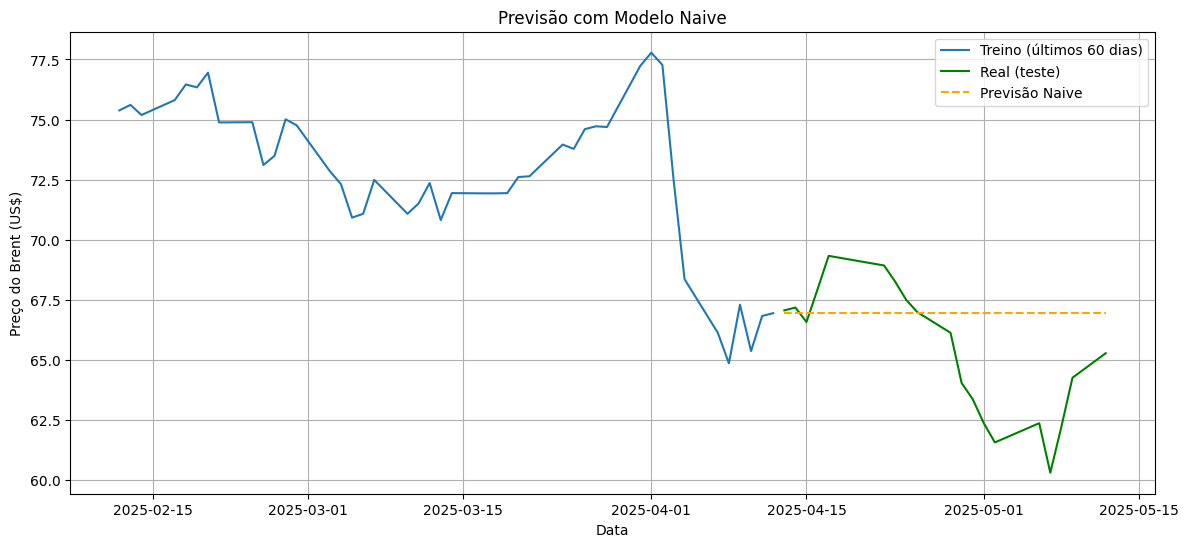

In [29]:
plt.figure(figsize=(14,6))
plt.plot(train.index[-60:], train["Valor"].iloc[-60:], label="Treino (últimos 60 dias)")
plt.plot(test.index, y_true, label="Real (teste)", color="green")
plt.plot(test.index, y_pred, label="Previsão Naive", linestyle="--", color="orange")
plt.title("Previsão com Modelo Naive")
plt.xlabel("Data")
plt.ylabel("Preço do Brent (US$)")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
resultado_naive = avaliar_modelo(y_true, y_pred, "Naive")

## 4.2 - XGBoost

In [31]:
# Reindexar e interpolar
df_xgb = df.set_index("Data").asfreq("D")
df_xgb["Valor"] = df_xgb["Valor"].interpolate(method="linear")

In [32]:
# Criar features de lag
df_xgb["lag1"] = df_xgb["Valor"].shift(1)
df_xgb["lag2"] = df_xgb["Valor"].shift(2)
df_xgb["lag7"] = df_xgb["Valor"].shift(7)

In [33]:
# Rolling mean
df_xgb["roll_mean_3"] = df_xgb["Valor"].rolling(3).mean()
df_xgb["roll_mean_7"] = df_xgb["Valor"].rolling(7).mean()

In [34]:
# Features de data
df_xgb["day"] = df_xgb.index.day
df_xgb["month"] = df_xgb.index.month
df_xgb["weekday"] = df_xgb.index.weekday

In [35]:
# Remover valores nulos (primeiras linhas com lag e rolling)
df_xgb.dropna(inplace=True)

In [36]:
X = df_xgb.drop("Valor", axis=1)
y = df_xgb["Valor"]

# Usar últimos 30 dias como teste
X_train, X_test = X[:-30], X[-30:]
y_train, y_test = y[:-30], y[-30:]

In [37]:
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [38]:
resultado_xgb = avaliar_modelo(y_true, y_pred, "XGBoost")

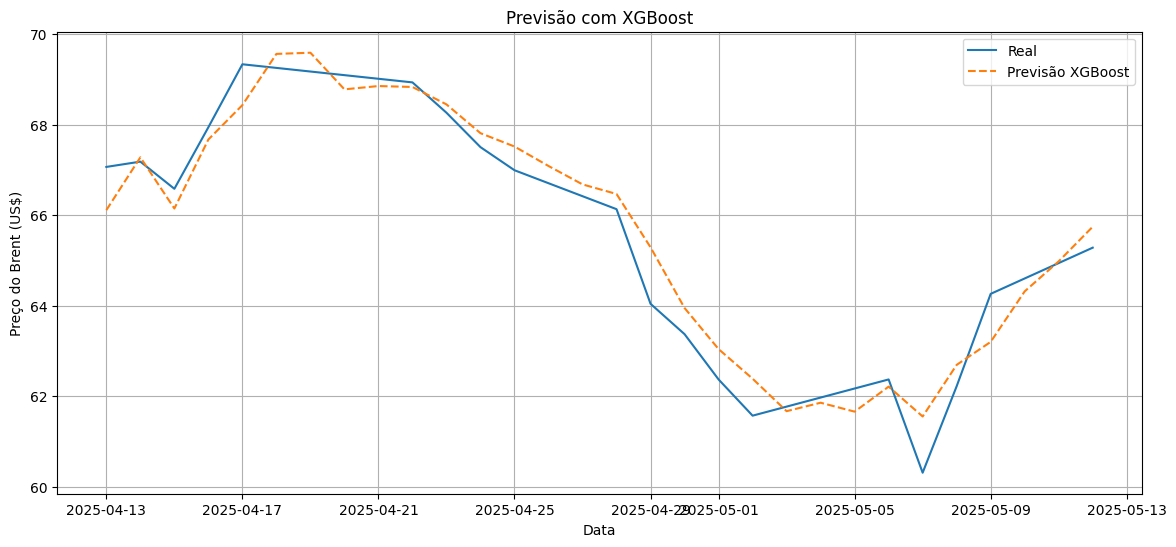

In [39]:
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label="Real")
plt.plot(y_test.index, y_pred, label="Previsão XGBoost", linestyle="--")
plt.title("Previsão com XGBoost")
plt.xlabel("Data")
plt.ylabel("Preço do Brent (US$)")
plt.legend()
plt.grid(True)
plt.show()

##

## 4.3 - LSTM

In [40]:
# 1. Base com frequência diária e preenchida
df_lstm = df.set_index("Data").asfreq("D")
df_lstm["Valor"] = df_lstm["Valor"].interpolate(method="linear")

In [41]:
# 2. Normalizar
scaler = MinMaxScaler()
df_lstm["Valor_scaled"] = scaler.fit_transform(df_lstm[["Valor"]])

In [42]:
# 3. Criar janelas de tempo
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 30  # Ex: usar os últimos 30 dias para prever o próximo
series = df_lstm["Valor_scaled"].values
X, y = create_sequences(series, window_size)

In [43]:
# 4. Dividir treino e teste
split = -30  # últimos 30 dias para teste
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [44]:
# 5. Redimensionar para [amostras, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [45]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, activation="relu", input_shape=(window_size, 1)))
lstm_model.add(Dense(1))  # Previsão de 1 valor

lstm_model.compile(optimizer="adam", loss="mse")

# Early stopping para evitar overfitting
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=16,
    callbacks=[es],
    verbose=1
)

Epoch 1/100


c:\Users\pedro\Documents\tech_challenge_4\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0132 - val_loss: 5.3654e-04
Epoch 2/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1.7581e-04 - val_loss: 4.8379e-04
Epoch 3/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1.7384e-04 - val_loss: 4.3691e-04
Epoch 4/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1.4470e-04 - val_loss: 3.4233e-04
Epoch 5/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1.2498e-04 - val_loss: 4.1991e-04
Epoch 6/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1.2350e-04 - val_loss: 2.9374e-04
Epoch 7/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1.1490e-04 - val_loss: 3.1881e-04
Epoch 8/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 1.1688e-04 - val_loss: 2.8581e-04
Epoch 9/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 1.2314e-04 - val_loss: 3.6445e-04
Epoch 10/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 1.1121e-04 - val_loss: 2.2083e-04
Epoch 11/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 1.

In [46]:
y_pred = lstm_model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


In [47]:
resultado_lstm = avaliar_modelo(y_test_rescaled, y_pred_rescaled, "LSTM")

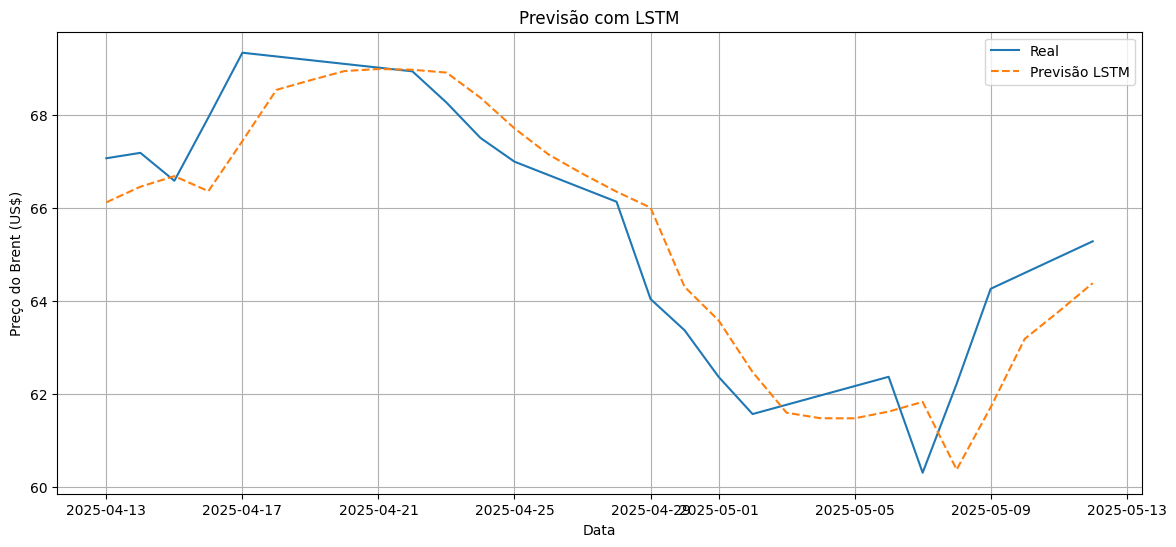

In [48]:
plt.figure(figsize=(14, 6))
plt.plot(df_lstm.index[-30:], y_test_rescaled, label="Real")
plt.plot(df_lstm.index[-30:], y_pred_rescaled, label="Previsão LSTM", linestyle="--")
plt.title("Previsão com LSTM")
plt.xlabel("Data")
plt.ylabel("Preço do Brent (US$)")
plt.legend()
plt.grid(True)
plt.show()

## 4.4 - Prophet

In [49]:
df_prophet = df.rename(columns={'Data': 'ds', 'Valor': 'y'})

In [50]:
# Separar os últimos 730 dias para teste
periodo = 730
data_final = df_prophet['ds'].max()
data_inicio = df_prophet['ds'].sort_values().iloc[-periodo]

#treino e teste
train_data = df_prophet[df_prophet['ds'] < data_inicio].copy()
test_data = df_prophet[df_prophet['ds'] >= data_inicio].copy()

In [51]:
prophet_model = Prophet(daily_seasonality=True)
prophet_model.add_seasonality(name='weekly', period=7, fourier_order=5)
prophet_model.fit(train_data)

19:06:05 - cmdstanpy - INFO - Chain [1] start processing
19:06:23 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
# Criar datas futuras incluindo o período de teste
fut = prophet_model.make_future_dataframe(periods=30)

# Gerar previsões
previsao = prophet_model.predict(fut)

# Extrair previsões apenas para o período de teste
prev_test = previsao[previsao['ds'].isin(test_data['ds'])][['ds', 'yhat']].reset_index(drop=True)
real_test = test_data[['ds', 'y']].reset_index(drop=True)

In [53]:
comparacao = pd.merge(real_test, prev_test, on='ds', how='inner')

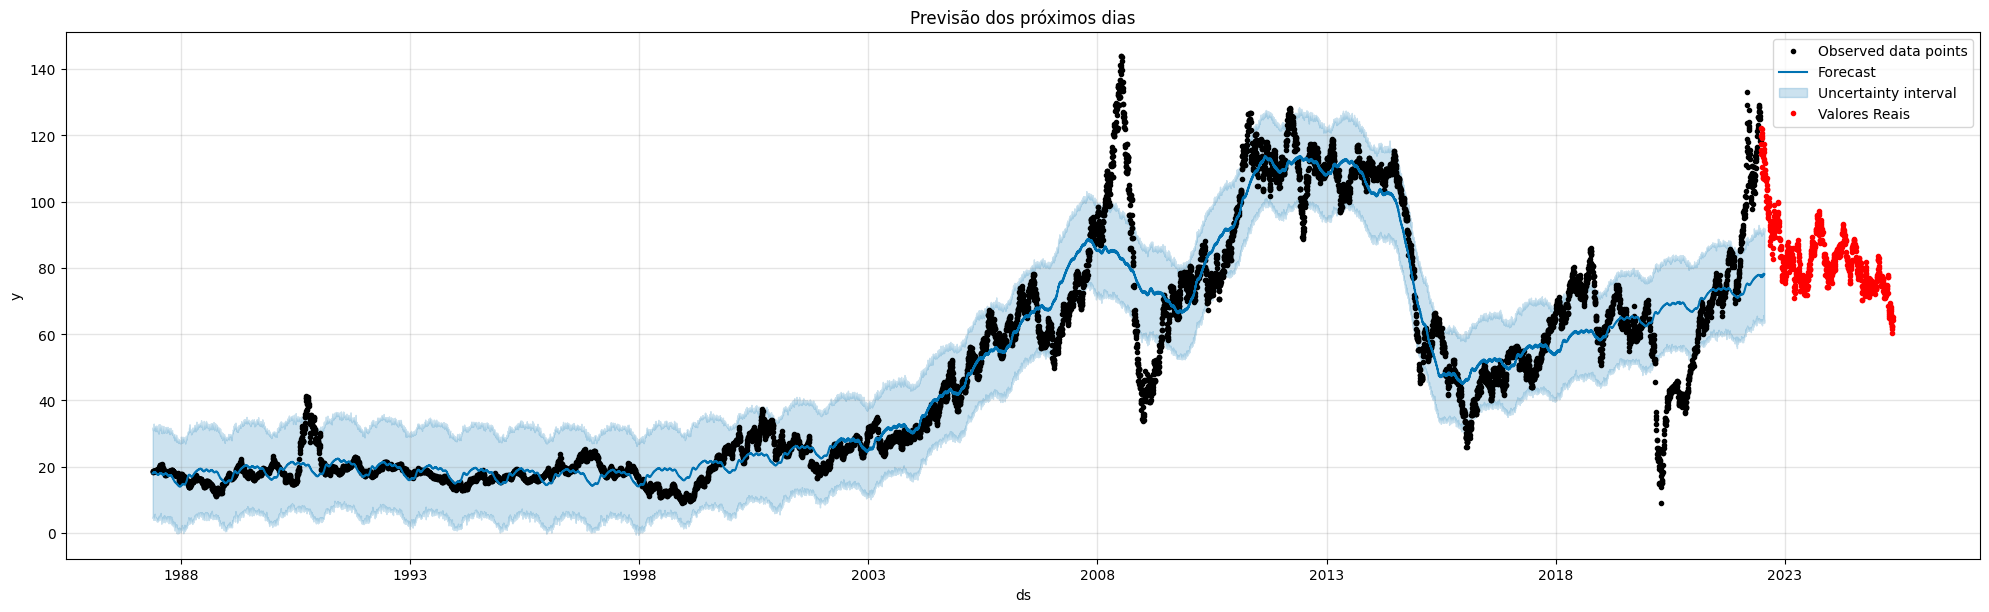

In [54]:
fig = prophet_model.plot(previsao, figsize=(20, 6))
plt.plot(test_data['ds'], test_data['y'], '.r', label='Valores Reais')
plt.title(f'Previsão dos próximos dias')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
resultado_prophet = avaliar_modelo(comparacao['y'], comparacao['yhat'], "prophet")

# 05 - Avaliação dos modelos e Export

In [56]:
resultados = pd.DataFrame([
    resultado_naive,
    resultado_xgb,
    resultado_lstm,
    resultado_prophet
])

print(resultados)

    Modelo     MAE    RMSE      R²
0    Naive   2.477   3.084  -0.254
1  XGBoost   0.457   0.567   0.958
2     LSTM   0.877   1.079   0.846
3  prophet  37.266  37.558 -66.102


In [57]:
# Export do modelo escolhido

# Exportar modelo
joblib.dump(xgb_model, r'C:\Users\pedro\Documents\tech_challenge_4\Modelo\xgb_petroleo_model2.pkl')
print('Modelo XGBoost exportado')

Modelo XGBoost exportado
